### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import correlation
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
# Load the dataset
df = pd.read_csv('book_ratings.csv', encoding='ISO-8859-1', sep=';')
df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


#### Because of the large size of dataset, i take a smaller subset of the data.

In [3]:
df_sample = df.sample(frac=0.05, random_state=1)  # Take a random 5% sample
print("\nDataset shape:", df_sample.shape)
df_sample.head()


Dataset shape: (57489, 3)


,User-ID,ISBN,Book-Rating
323188,76798,2070213951,0
97807,22281,8401461170,10
1044825,249939,0441003745,8
475573,113904,0670815616,0
799887,194151,0399144315,7


### Create a Rating Matrix (Scoring Matrix)
Transform the data into a user-item matrix, where rows represent users and columns represent books.

In [4]:
# Create a pivot table with users as rows, books as columns, and ratings as values
rating_matrix = df_sample.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
# Fill NaN values with average of ratings
rating_matrix_filled = rating_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
rating_matrix_filled.head()

ISBN,0586045007,0 7322 6794 3,00000000,000000000000,0000000008573,0000014427,0000018030,000060193395,0001046624,0001372564,...,O67697O753,O770109853,O878391045,Q912838027,SBN425037452,SELBSTVERLAG,TERESA155,XXXXXXXXXX,"\8887517452\""""","\8888809228\"""""
User-ID,,,,,,,,,,,,,,,,,,,,,
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
83,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
183,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,...,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667,7.666667


### Analyze the Dataset

In [5]:
df_sample.dtypes

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

Number of users: 17757
Number of books: 40582
Rating distribution:
0     35937
8      5228
10     3893
7      3850
9      3313
5      2491
6      1832
4       440
3       281
2       143
1        81
Name: Book-Rating, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_8660\2199334521.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, x='Book-Rating', palette="viridis")


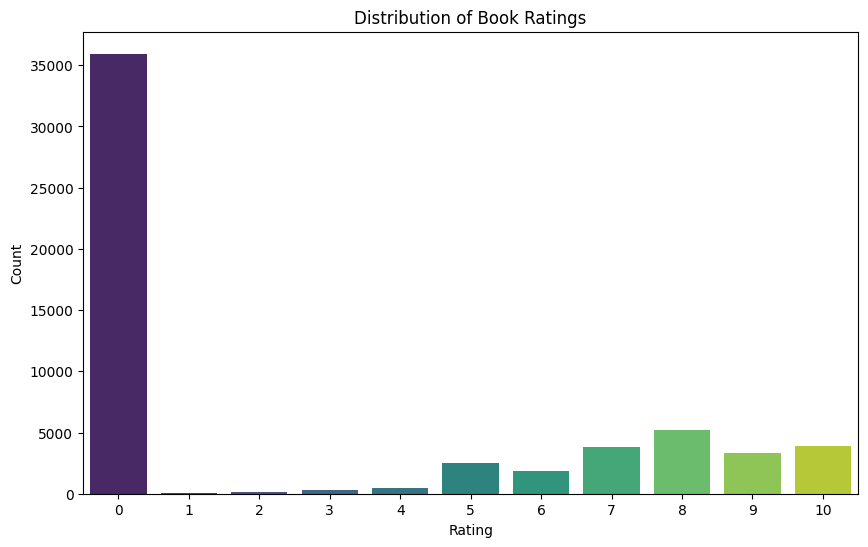

In [6]:
# Number of unique users and books
num_users = df_sample['User-ID'].nunique()
num_books = df_sample['ISBN'].nunique()
print(f'Number of users: {num_users}')
print(f'Number of books: {num_books}')

# Rating distribution
rating_counts = df_sample['Book-Rating'].value_counts()
print('Rating distribution:')
print(rating_counts)

# Plot the rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sample, x='Book-Rating', palette="viridis")
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Calculate Similarity between Users by Pearson Correlation
It was successful bc the runtime was over an hour so i used cosine similiraity!

In [7]:
# Calculate Pearson correlation between users
# cor_user_similarity = rating_matrix_filled.T.corr(method='pearson')
# core_user_similarity_df = pd.DataFrame(cor_user_similarity, index=rating_matrix_filled.index, columns=rating_matrix_filled.index)

### Calculate Similarity between Users by Cosine Similarity

In [8]:
# Calculate cosine similarity between users
user_similarity = cosine_similarity(rating_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=rating_matrix_filled.index, columns=rating_matrix_filled.index)

In [27]:
def recommend_books(user_id, rating_matrix, user_similarity_df, n_recommendations=5):
    # Get the similarity scores for the given user with all other users
    user_similarities = user_similarity_df[user_id]
    
    # Get ratings of similar users
    similar_user_ratings = rating_matrix.mul(user_similarities, axis=0)
    
    # Sum the weighted ratings and normalize by the sum of similarities
    weighted_scores = similar_user_ratings.sum(axis=0) / (user_similarities.sum() + 1e-8)
    
    # Filter out books the user has already rated
    rated_books = rating_matrix.loc[user_id][rating_matrix.loc[user_id] > 0].index
    recommendations = weighted_scores.drop(index=rated_books).nlargest(n_recommendations)
    
    return recommendations.index.tolist()

In [28]:
# Choose a random user ID from the sample data
random_user_id = df_sample['User-ID'].iloc[random.randint(0, rating_matrix.shape[0])]
print(f"Testing recommendations for Random User ID: {random_user_id}")

# Get recommended books for the randomly selected user
recommended_books = recommend_books(random_user_id, rating_matrix_filled, user_similarity_df)
print(f"Recommended books for User {random_user_id}: {recommended_books}")


Testing recommendations for Random User ID: 67840
Recommended books for User 67840: ['0446611778', '0451179803', '0060217863', '0689835825', '0836280660']
